In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pysrc.optimization.gurobi import solve_planner_problem
from pysrc.sampling import baseline
from pysrc.services.data_service import load_site_data
from pysrc.analysis import value_decomposition, transfers_decomposition

## Model scenario

In [2]:
pee = 7.6
pa = 41.11
sitenum = 1043
T = 200

In [3]:
# Load site data
(
    zbar_2017,
    z_2017,
    forest_area_2017,
    _,
    _,
    _,
    _,
) = load_site_data(sitenum)

# Set productivity parameters using baseline mean
baseline_fit = baseline.sample(
    num_sites=sitenum,
    iter_sampling=10**4,
    chains=5,
    seed=1,
)

theta = baseline_fit.stan_variable("theta").mean(axis=0)
gamma = baseline_fit.stan_variable("gamma").mean(axis=0)

# Computing carbon absorbed in start period
x0_vals = gamma * forest_area_2017

Data successfully loaded from /Users/ph2696/Projects/project-amazon/data/calibration/hmc


11:02:53 - cmdstanpy - INFO - compiling stan file /Users/ph2696/Projects/project-amazon/stan_model/baseline.stan to exe file /Users/ph2696/Projects/project-amazon/stan_model/baseline


Data successfully loaded from /Users/ph2696/Projects/project-amazon/data/calibration/hmc


11:02:58 - cmdstanpy - INFO - compiled model executable: /Users/ph2696/Projects/project-amazon/stan_model/baseline
11:03:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |          | 00:00 Status





chain 1 |▏         | 00:01 Iteration:    1 / 10000 [  0%]  (Sampling)







chain 1 |▎         | 00:01 Iteration:  100 / 10000 [  1%]  (Sampling)



chain 1 |▎         | 00:02 Iteration:  200 / 10000 [  2%]  (Sampling)








chain 1 |▍         | 00:02 Iteration:  300 / 10000 [  3%]  (Sampling)





chain 1 |▌         | 00:03 Iteration:  400 / 10000 [  4%]  (Sampling)





chain 1 |▋         | 00:03 Iteration:  500 / 10000 [  5%]  (Sampling)




chain 1 |▋         | 00:04 Iteration:  600 / 10000 [  6%]  (Sampling)





chain 1 |▊         | 00:04 Iteration:  700 / 10000 [  7%]  (Sampling)





chain 1 |▉         | 00:05 Iteration:  800 / 10000 [  8%]  (Sampling)





chain 1 |▉         | 00:05 Iteration:  900 / 10000 [  9%]  (Sampling)







11:03:53 - cmdstanpy - INFO - CmdStan done processing.


In [28]:
results_15 = solve_planner_problem(
    T=T,
    theta=theta,
    gamma=gamma,
    x0=x0_vals,
    zbar=zbar_2017,
    z0=z_2017,
    pe=pee + 3 * 5,
    pa=pa,
)

results_25 = solve_planner_problem(
    T=T,
    theta=theta,
    gamma=gamma,
    x0=x0_vals,
    zbar=zbar_2017,
    z0=z_2017,
    pe=pee + 5 * 5,
    pa=pa,
)

Solving the optimization problem...
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file /var/folders/d1/k6sr3htd7fdgk614mmq8pwq00000gr/T/tmpbzlercli.pyomo.lp
Reading time = 1.04 seconds
x1: 417400 rows, 834601 columns, 2083071 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 417400 rows, 834601 columns and 2083071 nonzeros
Model fingerprint: 0x402b54d3
Model has 200 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [5e-04, 4e+03]
  QObjective range [3e+03, 2e+05]
  Bounds range     [3e-06, 1e+00]
  RHS range        [9e-11, 5e-01]
Presolve removed 208947 rows and 209294 columns
Presolve time: 0.30s
Presolved: 208453 rows, 625307 columns, 1249370 nonzeros
Presolved model has 200 quadratic objective terms
Ordering time: 0.01s

B

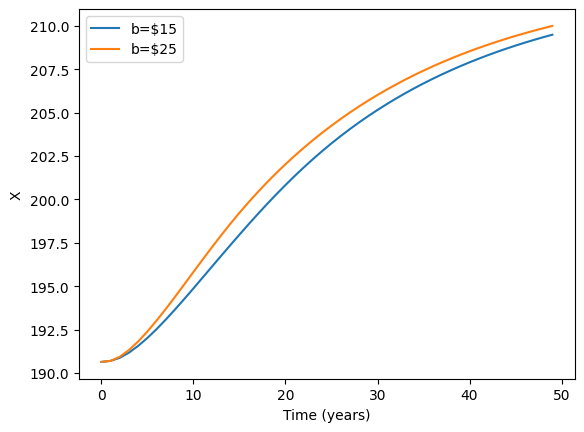

In [29]:
# Plotting the line plots for V and W
plt.plot(results_15["X"].sum(axis=1)[:50], label="b=$15")
plt.plot(results_25["X"].sum(axis=1)[:50], label="b=$25")


# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel("Time (years)")
plt.ylabel("X")

# Displaying the plot
plt.show()

In [44]:
x0_vals.sum()

190.6428131502195

In [46]:
X[1].sum() - X[0].sum()

0.06158572423370856

In [42]:
X[0].sum()

190.6428131502195

0.06158572421793482
0.06158572423368981


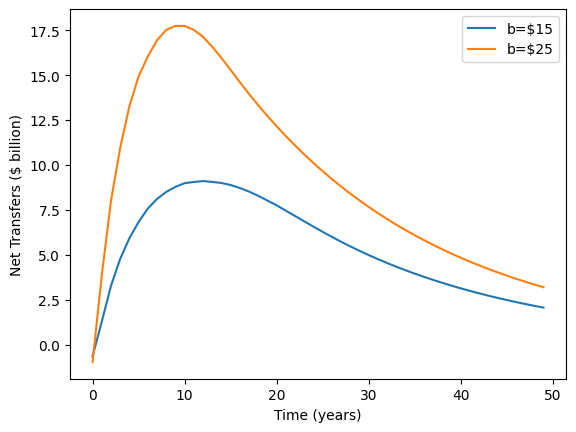

In [52]:
for b, results in zip([15, 25], [results_15, results_25]):
    kappa = 2.094215255
    X = results["X"]
    Z = results["Z"]

    # Compute X_dot
    X_dot = np.diff(X, axis=0)
    print(X_dot[0].sum())

    # Compute transfers
    transfers = -b * (kappa * Z[1:] - X_dot).sum(axis=1)

    # Plotting transfers
    plt.plot(transfers[:50], label=f"b=${b}")

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel("Time (years)")
plt.ylabel("Net Transfers ($ billion)")

# Displaying the plot
plt.show()

0.06158572421793482
0.06158572423368981


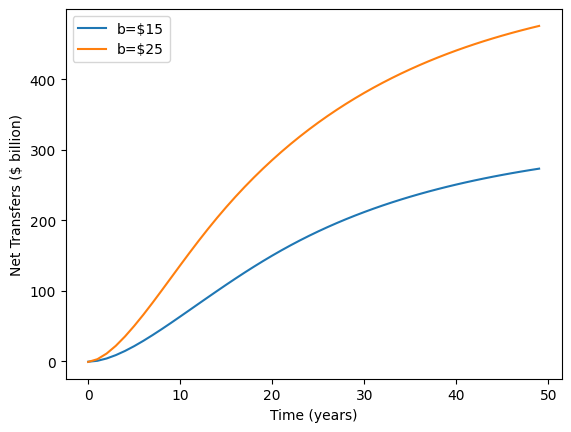

In [53]:
for b, results in zip([15, 25], [results_15, results_25]):
    kappa = 2.094215255
    X = results["X"]
    Z = results["Z"]

    # Compute X_dot
    X_dot = np.diff(X, axis=0)
    print(X_dot[0].sum())

    # Compute transfers
    transfers = -b * (kappa * Z[1:] - X_dot).sum(axis=1)
    cum_transfers = transfers.cumsum()

    # Plotting transfers
    plt.plot(cum_transfers[:50], label=f"b=${b}")

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel("Time (years)")
plt.ylabel("Net Transfers ($ billion)")

# Displaying the plot
plt.show()